Using device: cuda
Epoch 0/1000, Loss: 0.0979
Epoch 100/1000, Loss: 0.0444
Epoch 200/1000, Loss: 0.0307
Epoch 300/1000, Loss: 0.0244
Epoch 400/1000, Loss: 0.0207
Epoch 500/1000, Loss: 0.0182
Epoch 600/1000, Loss: 0.0164
Epoch 700/1000, Loss: 0.0151
Epoch 800/1000, Loss: 0.0140
Epoch 900/1000, Loss: 0.0131
Test Accuracy: 100.00%


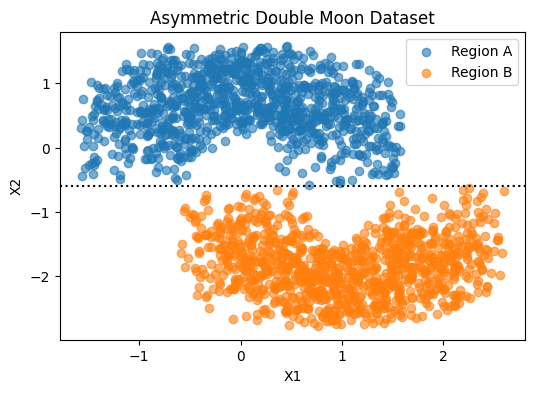

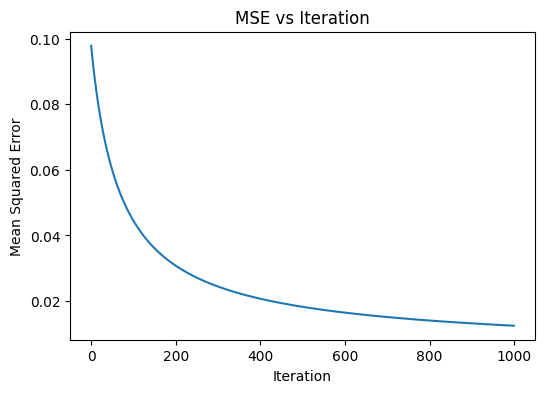

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Checking CUDA (trained on GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def generate_asymmetric_double_moon(n_samples=2000, w=0.6, d=1.2, r=1.0):
    """Generate asymmetrically arranged double moon dataset."""
    angles = np.linspace(0, np.pi, n_samples // 2)
    
    # Upper moon (symmetric with respect to y-axis)
    x1 = r * np.cos(angles) + np.random.uniform(-w, w, size=angles.shape)
    y1 = r * np.sin(angles) + np.random.uniform(-w, w, size=angles.shape)
    region_A = np.vstack((x1, y1)).T

    # Lower moon (shifted right by r and down by d)
    x2 = r * np.cos(angles) + np.random.uniform(-w, w, size=angles.shape) + r
    y2 = -r * np.sin(angles) - d + np.random.uniform(-w, w, size=angles.shape)
    region_B = np.vstack((x2, y2)).T

    X = np.vstack((region_A, region_B))
    y = np.hstack((np.ones(n_samples // 2), -np.ones(n_samples // 2)))  # Labels: 1 for A, -1 for B
    return X, y

# Generate dataset
X, y = generate_asymmetric_double_moon()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to GPU
tensor_X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
tensor_y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
tensor_X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
tensor_y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Define a single-layer neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(2, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# Initialize model and move it to GPU if available
model = SimpleNN().to(device)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the Neural Network
losses = []
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(tensor_X_train)
    loss = criterion(outputs, (tensor_y_train + 1) / 2)  # Convert labels to 0 and 1
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

# Predict on Test Data
with torch.no_grad():
    test_outputs = model(tensor_X_test)
    test_predictions = (test_outputs >= 0.5).float()  # Convert to 0 or 1
    test_predictions = test_predictions * 2 - 1  # Convert back to -1 and 1

# Compute Accuracy
correct_predictions = (test_predictions == tensor_y_test).sum().item()
accuracy = correct_predictions / len(y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot the scatter plot of the dataset with a dotted separation line
plt.figure(figsize=(6, 4))
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Region A', alpha=0.6)
plt.scatter(X[y == -1, 0], X[y == -1, 1], label='Region B', alpha=0.6)
plt.axhline(y=-0.6, color='k', linestyle='dotted', linewidth=1.5)  # Dotted line for separation
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Asymmetric Double Moon Dataset")
plt.savefig("asymmetric_double_moon.png", dpi=300)
plt.show()

# Plot Mean Squared Error vs Iterations
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), losses)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Iteration")
plt.savefig("mse_vs_iteration.png", dpi=300)
plt.show()
